In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Fatality
1. India at each city or state level, whichever data is available
2. US by lat lon, needs to be aggregated
3. Brazil only has 2019 from literature
4. HK and Taipei uses WSD data
3. All countries level
4. Redistribute to each city. Calculate the fatality rate per city = people killed/state-level population
5. For HK, US we have location-level data to use directly to find fatal accidents

```
country
state/province
year
total_accident
total_fatal_accident
num_person_killed
num_person_kille_per_lakh (per 100,000 population)
```

In [2]:
# load all cities from gspread
import gspread
def load_all():
    serviceaccount = "/Users/yuan/Dropbox (Personal)/personal files/ssh/google_drive_personal.json"
    import gspread

    # from oauth2client.service_account import ServiceAccountCredentials
    gc = gspread.service_account(filename=serviceaccount)


    def read_url(url, SHEET_NAME):
        SHEET_ID = url.split("/")[5]
        spreadsheet = gc.open_by_key(SHEET_ID)
        worksheet = spreadsheet.worksheet(SHEET_NAME)
        rows = worksheet.get_all_records()
        df_spread = pd.DataFrame(rows)
        return df_spread, worksheet


    url = "https://docs.google.com/spreadsheets/d/1o5gFmZPUoDwrrbfE6M26uJF3HnEZll02ivnOxP6K6Xw/edit?usp=sharing"
    SHEETNAME = "select_city_classifier"
    city_meta, other_worksheet = read_url(url, SHEETNAME)
    city_meta = city_meta[city_meta['City']!=''].reset_index(drop = True)
    city_meta["city_lower"] = city_meta["City"].apply(lambda x: x.lower().replace(" ", ""))
    return city_meta

city_meta = load_all()
# get a list of country
countryls = city_meta["Country"].unique()
print(countryls)

['Argentina' 'Australia' 'Austria' 'Bangladesh' 'Belgium' 'Bolivia'
 'Botswana' 'Brazil' 'Canada' 'Chile' 'China' 'Colombia' 'Denmark'
 'Ecuador' 'France' 'Germany' 'Ghana' 'Greece' 'Guatemala' 'Hungary'
 'India' 'Indonesia' 'Israel' 'Italy' 'Japan' 'Kenya' 'Lithuania'
 'Malaysia' 'Mexico' 'Netherlands' 'New Zealand' 'Nigeria' 'Peru'
 'Philippines' 'Poland' 'Republic of Korea' 'Russian Federation' 'Rwanda'
 'Serbia' 'Singapore' 'South Africa' 'Spain' 'Sweden' 'Thailand' 'Turkey'
 'Uganda' 'Ukraine' 'United Arab Emirates' 'United Kingdom'
 'United States' 'USA']


In [7]:
city_meta['city_country'] = city_meta['City']+", "+ city_meta['Country']

array(['Buenos Aires', 'Sydney', 'Vienna', 'Saidpur', 'Rajshahi', 'Dhaka',
       'Antwerp', 'Brussels', 'Cochabamba', 'Gaborone', 'Ilheus',
       'Jequie', 'Palmas', 'Florianopolis', 'Ribeirao Preto',
       'Belo Horizonte', 'Curitiba', 'Sao Paulo', 'Rio de Janeiro',
       'Victoria', 'Montreal', 'Toronto', 'Santiago', 'Taipei',
       'Hong Kong', 'Valledupar', 'Bogotá', 'Copenhagen', 'Quito',
       'Le Mans', 'Paris', 'Munich', 'Berlin', 'Accra', 'Thessaloniki',
       'Athens', 'Guatemala City', 'Budapest', 'Hindupur', 'Vijayawada',
       'Delhi', 'Bangalore', 'Kozhikode', 'Mumbai', 'Malegaon', 'Pune',
       'Parbhani', 'Jalna', 'Jaipur', 'Hyderabad', 'Sitapur', 'Kanpur',
       'Parepare', 'Cirebon', 'Medan', 'Palembang', 'Jakarta', 'Tel Aviv',
       'Jerusalem', 'Palermo', 'Rome', 'Milan', 'Yamaguchi', 'Tokyo',
       'Okayama', 'Fukuoka', 'Nagoya', 'Nairobi', 'Kaunas',
       'Kuala Lumpur', 'Guadalajara', 'Reynosa', 'Culiacan',
       'Mexico City', 'Zwolle', 'Amsterdam'

In [6]:
city_meta.groupby("Country")["City"].size().reset_index().sort_values('City').to_csv("country.csv", index = False)

In [92]:
starter_df = city_meta[['City','Country','State/Province','city_lower','country_clean', 'county_ls', 'urban_pop']]

In [2]:
ROOTFOLDER = "D:/Dropbox (Personal)/Personal Work/_Projects2023/01_city-never-was/_data"
RAWFOLDER = f"{ROOTFOLDER}/_raw/_road_fatality/_fatality"
EXPORTFOLDER = f"{ROOTFOLDER}/_transformed/t_road_fatality"
if not os.path.exists(EXPORTFOLDER):
    os.makedirs(EXPORTFOLDER)
india_path = ["India_num_person_killed_2019_2022.xlsx", 
              "India_total_accidents_2019_2022.xlsx",
              "India_num_fatal_accidents_state_2019_2022.xlsx"
              ]
us_path = "_US/FARS{year}NationalCSV/accident.csv"
other_path = "WRS Data 2000-2020 FINAL.csv"

In [3]:
india_mapping = dict(zip(
    ['State/UT-Wise Total Number of  Persons Killed in Road Accidents during',
       'Share of States/UTs in Total Number of Persons Killed in Road Accidents',
       'Total Number of Persons Killed in Road Accidents Per Lakh Population',
       'Total Number of Persons Killed in Road Accidents per 10,000 Vehicles',
       'Total Number of Persons Killed in Road Accidents per 10,000 Km of Roads',
       'State/UT-Wise Total Number of Road Accidents during',
       'Share of States/UTs in Total Number of Road Accidents',
       'Total Number of Accidents Per Lakh Population',
       'Total Number of  Road Accidents per 10,000\nVehicles',
       'Total Number of  Road Accidents per 10,000 Km of\nRoads'
       ],
    [
      "num_person_killed",
     "num_person_killed_share",
       "num_person_killed_per_lakh",
       "num_person_killed_per_10k_vehicle",
         "num_person_killed_per_10k_km_roads",
         "num_accidents",
          "num_accidents_share",
          "num_accidents_per_lakh",
          "num_accidents_per_10k_vehicle",
          "num_accidents_per_10k_km_roads"
         ]
))
vari_keep = ["num_person_killed", 
             "num_person_killed_per_lakh",
             "num_fatal_accidents",
             "num_accidents", 
             "num_accidents_per_lakh",
             "population"
             ]

### India data cleaning
1. State level
2. City level (for cities do not have data, use the state level rate directly)

In [4]:
# 2019-2022 India
india_df = pd.read_excel(os.path.join(RAWFOLDER, "India",india_path[0]), header = [0,1])
india_df_killed_long = india_df.melt(id_vars = [('States/Uts', 'Unnamed: 0_level_1')], 
              value_vars = list(india_df.columns[1:]), 
              var_name = ["variables","year"], value_name = "values").rename(columns = {('States/Uts', 'Unnamed: 0_level_1'):"state"})
india_df_killed_long['variables'] = india_df_killed_long['variables'].map(india_mapping)
india_df_killed_long['year'] = india_df_killed_long['year'].astype(int)
india_df_killed_long = india_df_killed_long[india_df_killed_long['variables'].isin(vari_keep)].reset_index(drop = True)
india_df_killed = india_df_killed_long.pivot(index = ["state","year"], columns = "variables", values = "values").reset_index()
# india_df_killed

# Number of Fatal Accidents
india_fatal_df = pd.read_excel(os.path.join(RAWFOLDER, "India",india_path[2]), header = [0]).rename(columns = {"States/UTs":"state"})
india_fatal_df = india_fatal_df.set_index("state").stack().reset_index().rename(columns = {"level_1":"year",0:"num_fatal_accidents"})

# Number of total accidents
india_accident_df = pd.read_excel(os.path.join(RAWFOLDER, "India",india_path[1]), header = [0,1])\
    .rename(columns = {"States/UTs":"state"})
india_accident_long = india_accident_df.melt(id_vars = [("state", "Unnamed: 0_level_1")], 
          value_vars = list(india_accident_df.columns[1:]), 
          var_name = ["variables","year"], value_name = "values").rename(columns = {("state", "Unnamed: 0_level_1"):"state"})
india_accident_long['variables'] = india_accident_long['variables'].map(india_mapping)
india_accident_long['year'] = india_accident_long['year'].astype(int)
india_accident = india_accident_long[india_accident_long['variables'].isin(vari_keep)].reset_index(drop = True)\
    .pivot(index = ["state","year"], columns = "variables", values = "values").reset_index()
    
    
statemapping = {'D & N Haveli':"Dadra & Nagar Haveli",
                "A & N Islands":"Andaman & Nicobar Islands",
                }
india_accident['state'] = india_accident['state'].apply(lambda x: statemapping[x] if x in statemapping.keys() else x)
india_df_killed['state'] = india_df_killed['state'].apply(lambda x: statemapping[x] if x in statemapping.keys() else x)
india_fatal_df['state'] = india_fatal_df['state'].apply(lambda x: statemapping[x] if x in statemapping.keys() else x)

india_df = india_accident.merge(
    india_df_killed, on = ["state","year"], how = "outer").merge(
    india_fatal_df, on = ["state","year"], how = "outer")
india_df['num_person_killed_per_lakh'] = india_df['num_person_killed_per_lakh'].apply(lambda x: x if x != "#" else np.nan)

,state,year,num_accidents,num_accidents_per_lakh,num_person_killed,num_person_killed_per_lakh,num_fatal_accidents
0,Andaman & Nicobar Islands,2019,230.0,39.1,20.0,3.4,20.0
1,Andaman & Nicobar Islands,2020,141,23.5,14,2.3,12.0
2,Andaman & Nicobar Islands,2021,115,28.8,20,5.0,19.0
3,Andaman & Nicobar Islands,2022,141,35.1,19,4.7,19.0
4,Andhra Pradesh,2019,21992.0,24.3,7984.0,8.8,7389.0


In [106]:
# 2013-2016 India state-level
india_df_2013_2016 = pd.read_excel(os.path.join(RAWFOLDER, "India", "Pages from Road_Accidents_in_India_2016-2-state.xlsx"),
                                   header = [0,1], index_col = 0)
india_df_2013_2016.stack().reset_index().rename(columns = {"level_0":"state","level_1":"year",})

States/UTs,state,year,State/UT-Wise Total Number of Road Accidents during,Share of States/UTs in Total Number of Road Accidents,Total Number of Accidents Per Lakh Population,"Total Number of Road Accidents per 10,000 Vehicles","Total Number of Road Accidents per 10,000 Km of Roads"
0,Andhra Pradesh,2013,43482.0,8.9,50.4,34.3,1661.8
1,Andhra Pradesh,2014,24440.0,5.0,28.1,34.9,1372.3
2,Andhra Pradesh,2015,24258.0,4.8,27.7,30.8,1355.0
3,Andhra Pradesh,2016,24888.0,5.2,28.2,NaN,NaN
4,Arunachal Pradesh,2013,308.0,0.1,24.3,20.4,109.6
...,...,...,...,...,...,...,...
139,Lakshadweep,2016,1.0,0.0,1.2,NaN,NaN
140,Puducherry,2013,1451.0,0.3,95.9,20.7,5020.5
141,Puducherry,2014,1111.0,0.2,70.6,14.8,3678.9
142,Puducherry,2015,1530.0,0.3,94.1,19.1,4980.2


In [93]:
# load city level data
columns_mapping = {
"Cities":"city",
"Fatal Accidents":"num_fatal_accidents",
"No. of Persons Killed":"num_person_killed",
"No of persons Killed":"num_person_killed",
"Total Accidents":"total_accidents",
"No. of Persons Injured":"num_person_injured",
"No of persons injured":"num_person_injured",
"Injury Accidents":"num_injury_accidents",
"Severity of Accidents":"severity",
"States/UTs":"city"
}
india_city = {
    "Bengaluru": "Bangalore",
}

india_2016 = pd.read_excel(os.path.join(RAWFOLDER, "India", "Pages from Road_Accidents_in_India_2016_city_level.xlsx"))


india_2016 = india_2016[india_2016['Cities'].notnull()].copy().rename(
    columns = columns_mapping
)
# india_2019 = india_2019[india_2019['States/UTs'].notnull()].copy().rename(
#     columns = columns_mapping
# )
india_2016['year'] = 2016

# map city names

In [98]:
india_2019 = pd.read_excel(os.path.join(RAWFOLDER, "India", "Pages from Road_Accidents_in_India_2019_city_level.xlsx"), 
                           header = [0,1], index_col = [0,1])
india_2019 = india_2019.stack().reset_index().rename(columns = {"level_1":"city","level_2":"year"}).rename(columns = columns_mapping)
# india_2019['year'] = 2019
india_city_df = pd.concat([india_2016, india_2019], axis = 0)
india_city_df['city'] = india_city_df['city'].apply(lambda x: india_city[x] if x in india_city.keys() else x)
india_city_df = india_city_df[['city','num_fatal_accidents','num_person_killed','total_accidents','num_person_injured','year']]

In [102]:
starter_india = starter_df[starter_df['Country'] == "India"].copy()
with_city_india = starter_india.merge(india_city_df, left_on = "City", right_on = "city", how = "inner")
with_city_india['num_person_killed_per_lakh'] = with_city_india['num_person_killed'] / with_city_india['urban_pop'] * 100000
with_city_india['fatality_source'] = "city_level"

no_city_india = starter_india[~starter_india['City'].isin(with_city_india['City'])].copy()
print(no_city_india['State/Province'].unique())
no_city_india = no_city_india.merge(india_df, left_on = "State/Province", right_on = "state", how = "inner")
print(no_city_india['State/Province'].unique())
no_city_india['fatality_source'] = "state_level"

['Andhra Pradesh' 'Kerala' 'Maharashtra' 'Uttar Pradesh']
['Andhra Pradesh' 'Kerala' 'Maharashtra' 'Uttar Pradesh']


,City,Country,State/Province,city_lower,country_clean,county_ls,urban_pop,state,year,num_accidents,num_accidents_per_lakh,num_person_killed,num_person_killed_per_lakh,num_fatal_accidents,country,source
0,Hindupur,India,Andhra Pradesh,hindupur,India,[],200000,Andhra Pradesh,2019,21992.0,24.3,7984.0,8.8,7389.0,India,GOVERNMENT OF INDIA
1,Hindupur,India,Andhra Pradesh,hindupur,India,[],200000,Andhra Pradesh,2020,19509,21.5,7039,7.7,6531.0,India,GOVERNMENT OF INDIA
2,Hindupur,India,Andhra Pradesh,hindupur,India,[],200000,Andhra Pradesh,2021,21556,40.8,8186,15.5,7585.0,India,GOVERNMENT OF INDIA
3,Hindupur,India,Andhra Pradesh,hindupur,India,[],200000,Andhra Pradesh,2022,21249,40.1,8293,15.7,7688.0,India,GOVERNMENT OF INDIA
4,Vijayawada,India,Andhra Pradesh,vijayawada,India,[],1467000,Andhra Pradesh,2019,21992.0,24.3,7984.0,8.8,7389.0,India,GOVERNMENT OF INDIA
5,Vijayawada,India,Andhra Pradesh,vijayawada,India,[],1467000,Andhra Pradesh,2020,19509,21.5,7039,7.7,6531.0,India,GOVERNMENT OF INDIA
6,Vijayawada,India,Andhra Pradesh,vijayawada,India,[],1467000,Andhra Pradesh,2021,21556,40.8,8186,15.5,7585.0,India,GOVERNMENT OF INDIA
7,Vijayawada,India,Andhra Pradesh,vijayawada,India,[],1467000,Andhra Pradesh,2022,21249,40.1,8293,15.7,7688.0,India,GOVERNMENT OF INDIA
8,Kozhikode,India,Kerala,kozhikode,India,[],2028399,Kerala,2019,41111.0,113.4,4440.0,12.3,4183.0,India,GOVERNMENT OF INDIA
9,Kozhikode,India,Kerala,kozhikode,India,[],2028399,Kerala,2020,27877,76.6,2979,8.2,2823.0,India,GOVERNMENT OF INDIA


# All other countries
1. The WRS Data has error in Brazil, only use it for Hong Kong and Taipei.
2. Use the WHO data instead: https://apps.who.int/gho/data/node.main.A997
* Note: WHO data does not have HK and Taiwan separated, need to fetch other sources

In [57]:
# these code process the WRS data, but found problem with the data, so not using it, only extract hong kong and taipei data from it
def get_hongkong_taipei():
    other_df = pd.read_csv(os.path.join(RAWFOLDER, other_path), header = [0,1,2])
    other_df.columns = [str("_".join(x)) for x in other_df.columns]
    other_df.rename(
        columns = {
            'Unnamed: 0_level_0_Unnamed: 0_level_1_Unnamed: 0_level_2':"country",
            'Unnamed: 1_level_0_Unnamed: 1_level_1_Unnamed: 1_level_2':"country_abbr"
        }, inplace = True
    )
    keyword = ["Total Persons Killed", "Persons Killed Rate", "Fatal Accidents", "Injury Accidents"]
    selcols = [x for x in other_df.columns if any([y in x for y in keyword])]
    # pivot the table, index are country and year, 
    # columns are Total Persons Killed, Persons Killed Rate, Fatal Accidents, values are the values
    # Persons Killed Rate: number of fatalities per 100,000 population
    index_ls = ['country', 'year']
    other_df_long = other_df.melt(id_vars = ['country'], 
                                value_vars = selcols, 
                                var_name = 'variable', 
                                value_name = 'value')
    other_df_long["year"] = other_df_long["variable"].str.extract(r'(\d{4})')
    other_df_long["variable"] = other_df_long["variable"].str.extract(r'([a-zA-Z\s]+)')

    other_vari_mapping = dict(zip(
        ['Total Persons Killed', 'Persons Killed Rate', 'Fatal Accidents', 'Injury Accidents'],
        ["num_person_killed", "num_person_killed_per_lakh","num_fatal_accidents", "num_injury_accidents"]
    ))
    other_df_long['variable'] = other_df_long['variable'].apply(lambda x: other_vari_mapping[x] if x in other_vari_mapping.keys() else x)
    other_df = other_df_long.pivot(index =index_ls, columns = "variable", values = "value").reset_index()
    return other_df[other_df['country'].isin(["China, Hong Kong", "Chinese Taipei"])][['country','year','num_person_killed','num_person_killed_per_lakh','num_fatal_accidents','num_injury_accidents']]
th = get_hongkong_taipei()
th['state'] = np.where(th['country'] == "China, Hong Kong", "Hong Kong", "Taiwan")
th['country'] = "China"
th.head()

variable,country,year,num_person_killed,num_person_killed_per_lakh,num_fatal_accidents,num_injury_accidents,state
840,China,2000,171,2.57,NaN,"14,949",Hong Kong
841,China,2001,173,2.58,NaN,"15,631",Hong Kong
842,China,2002,171,2.54,NaN,"15,576",Hong Kong
843,China,2003,202,3.0,NaN,"14,436",Hong Kong
844,China,2004,166,2.45,NaN,"15,026",Hong Kong


In [43]:
# load raw all other country's data.
df_other = pd.read_csv(os.path.join(RAWFOLDER, "who_road_fatality.csv"), header = [0,1])
df_other.columns = [str("_".join(x)) for x in df_other.columns]
df_other.rename(columns = {
    "Unnamed: 0_level_0_Countries, territories and areas":"country",
    "Unnamed: 1_level_0_Year":"year",
    "Estimated number of road traffic deaths_Both sexes":"num_person_killed",
    "Estimated road traffic death rate (per 100 000 population)_Both sexes":"num_person_killed_per_lakh",
}, inplace = True)
df_other = df_other[['country','year','num_person_killed','num_person_killed_per_lakh']]
df_other['num_person_killed'] = df_other['num_person_killed'].apply(lambda x: float(x.split(" [")[0]))
df_other['num_person_killed_per_lakh'] = df_other['num_person_killed_per_lakh'].apply(lambda x: float(x.split(" [")[0]))
df_other['num_person_killed_per_lakh'].describe()

count    3660.000000
mean       18.050000
std         9.062257
min         0.000000
25%        11.275000
50%        16.750000
75%        25.200000
max        64.600000
Name: num_person_killed_per_lakh, dtype: float64

### Brazil
* https://datasus.saude.gov.br/transferencia-de-arquivos/#
* https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9038143/

In [60]:
df_brazil = pd.read_excel(os.path.join(RAWFOLDER, "_brazil/fatality_daly_brazil_2019.xlsx"), header = [0,1])
columns_keep = [(        'Unnamed: 0_level_0',       'state'), 
                (         'num_person_killed',           'n'),
                ('num_person_killed_per_lakh',           'n'),
                (                 'DALY Rate',       'value'),]
df_brazil = df_brazil[columns_keep].droplevel(1, axis = 1).rename(columns = {'Unnamed: 0_level_0':'state'})
# remove state name encoding, put into clean English name
df_brazil['state_original'] = df_brazil['state']
encodingmapping = {
    "á":"a",
    "é":"e",
    "ã":"a",
    "í":"i",
}
df_brazil['state'] = df_brazil['state'].apply(lambda x: "".join([encodingmapping[y] if y in encodingmapping.keys() else y for y in x]))
df_brazil['country'] = 'Brazil'
df_brazil['year'] = 2019
df_brazil.head()

,state,num_person_killed,num_person_killed_per_lakh,DALY Rate,state_original,country,year
0,Brazil,44529,19.1,1061,Brazil,Brazil,2019
1,Acre,143,16.3,895,Acre,Brazil,2019
2,Alagoas,855,23.3,1244,Alagoas,Brazil,2019
3,Amapa,134,16.7,951,Amapá,Brazil,2019
4,Amazonas,536,13.5,712,Amazonas,Brazil,2019


# US data cleaning per state and county
1. county population
2. county shape
3. spatial join to get fatality, accident, number of person killed

In [44]:
# load population data
ACS_ROOT = "D:/Dropbox (Personal)/Personal Work/_commondata/ACS"
county_2022 = "{ACS_ROOT}/2022/R13563710_SL050.csv"
county_2020 = "{ACS_ROOT}/2020/R13668097_SL050.csv"
county_2016 = "{ACS_ROOT}/2016/R13668096_SL050.csv"
county_2016_df = pd.read_csv(county_2016.format(ACS_ROOT = ACS_ROOT))[1:][['Total Population', 'FIPS']]
county_2020_df = pd.read_csv(county_2020.format(ACS_ROOT = ACS_ROOT))[1:][['Total Population', 'FIPS']]
county_2022_df = pd.read_csv(county_2022.format(ACS_ROOT = ACS_ROOT))[1:][['Total Population', 'FIPS']]
county_2020_df.rename(columns = {"Total Population":"population","FIPS":"county_fips"}, inplace = True)
county_2016_df.rename(columns = {"Total Population":"population","FIPS":"county_fips"}, inplace = True)
county_2022_df.rename(columns = {"Total Population":"population","FIPS":"county_fips"}, inplace = True)
county_2020_df['year'] = 2020
county_2016_df['year'] = 2016
county_2022_df['year'] = 2022

# expand the data from 2016 to 2020, for year before 2019, use the 2016 data, for year 2021, use the 2020 data
county_df = []
for year in range(2016, 2023):
    if year < 2019:
        # county_df[year] = county_df['population']
        temp = county_2016_df.copy()
        temp['year'] = year
    elif year == 2021:
        temp = county_2020_df.copy()
        temp['year'] = year
    else:
        temp = county_2022_df.copy()
        temp['year'] = year
    county_df.append(temp)
county_df = pd.concat(county_df)
county_df['county_fips'] = county_df['county_fips'].astype(str).str.zfill(5)

C:\Users\yuanzfan\AppData\Local\Temp\ipykernel_20712\3086470882.py:8: DtypeWarning: Columns (0,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,

In [46]:
# load raw
for year in range(2016, 2023):
    us_df = pd.read_csv(os.path.join(RAWFOLDER, us_path.format(year = year)), 
                        engine = "python",
                        # error_bad_lines = False,
                        encoding = 'ISO-8859-1'
                        )
    us_df["year"] = year
    if year == 2016:
        us_df_all = us_df
    else:
        us_df_all = pd.concat([us_df_all, us_df], 
                              axis = 0)

In [47]:
us_df = us_df_all[[
    'ST_CASE',
    'YEAR','MONTH',
    'COUNTY', 
    'COUNTYNAME',
    'PERSONS',
    'CITY', 'CITYNAME', 
    'LATITUDE', 'LONGITUD',
    'FATALS','DRUNK_DR',
    'STATE', 'STATENAME',
    'ROUTE', 'ROUTENAME',
    'DAY_WEEK', 'DAY_WEEKNAME', 
    'HOUR', 'HOURNAME', 'MINUTE',
    ]].reset_index(drop = True)
us_df.columns = [x.lower() for x in us_df.columns]
us_df.rename(columns = {'longitud':'longitude'}, inplace = True)
us_df['county_fips'] = us_df['state'].astype(str).str.zfill(2)+us_df['county'].astype(str).str.zfill(3)
us_df['state_fips'] = us_df['state'].astype(str).str.zfill(2)
for f in ['longitude', 'latitude']:
    us_df[f] = us_df[f].astype(float)
us_df['county_fips'].nunique()

3137

In [49]:
# aggregate the data to county level, state level, and find associated population of each state and county
us_df['num_person_killed'] = us_df['fatals']
us_df['num_fatal_accidents'] = 1
county_level = us_df.groupby(['county_fips','countyname','state_fips','statename','year']).agg(
    num_person_killed = ("num_person_killed","sum"),
    num_fatal_accidents = ("num_fatal_accidents","sum"),
).reset_index().merge(county_df, on = ['county_fips','year'], how = "left")
county_level['population'] = county_level['population'].astype(float)
county_level['num_person_killed_per_lakh'] = county_level['num_person_killed']/county_level['population']*100000
county_level['countyname'] = county_level['countyname'].apply(lambda x: x.split(" (")[0] if " (" in x else x)
county_level.rename(columns = {'statename':"state"}, inplace = True)
county_level.head()

,county_fips,countyname,state_fips,state,year,num_person_killed,num_fatal_accidents,population,num_person_killed_per_lakh
0,01001,AUTAUGA,01,Alabama,2016,15,15,55049.0,27.248451
1,01001,AUTAUGA,01,Alabama,2017,14,14,55049.0,25.431888
2,01001,AUTAUGA,01,Alabama,2018,9,9,55049.0,16.349071
3,01001,AUTAUGA,01,Alabama,2019,11,9,58761.0,18.719899
4,01001,AUTAUGA,01,Alabama,2020,7,7,58761.0,11.912663


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
 

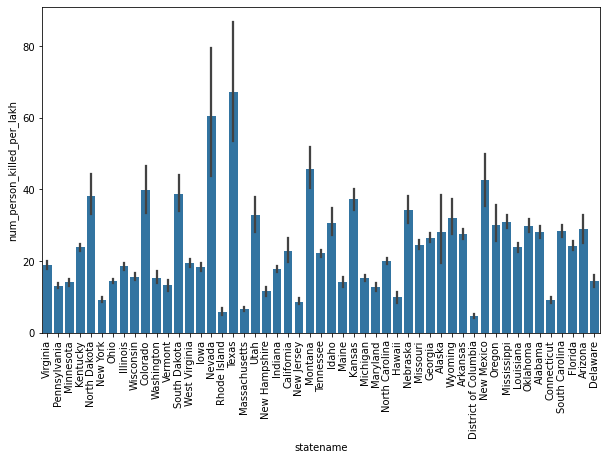

In [170]:
fig, ax = plt.subplots(figsize = (10,6))
sns.barplot(data = county_level.sort_values("num_person_killed_per_lakh"), 
            x = "statename", y = "num_person_killed_per_lakh")
# rotate the x-axis labels
plt.xticks(rotation=90)

## Taiwan & Hong Kong use WSD for now
- https://168.motc.gov.tw/en/countrydeadhurt/%E8%87%BA%E5%8C%97%E5%B8%82
- https://www.statista.com/statistics/320553/taiwan-road-traffic-fatalities/

## Combine All

In [61]:
# export the data combined
india_df['country'] = "India"
county_level['country'] = "United States"
india_df['source'] = "GOVERNMENT OF INDIA"
th['source'] = "WRS"
df_other['source'] = "WHO"

df_brazil['source'] = "Malta (2022)"
county_level['source'] = "US-NHTSA"
fatality_df = pd.concat([india_df, th, df_other, df_brazil, county_level], axis = 0)

In [67]:
# df_other[~df_other['country'].str.contains('United States')].reset_index(drop= True)

In [63]:

fatality_df.to_csv(os.path.join(EXPORTFOLDER, "t_fatality_country_state_county_year.csv"), index = False)

## Location level (US, HK only)

In [ ]:
# assign h3 6, 9, 12 index to each accident
import h3
def get_h3_index(row, res = 6):
    return h3.geo_to_h3(row['latitude'], row['longitude'], res)
us_df['h3_6'] = us_df.apply(get_h3_index, axis = 1)
us_df['h3_9'] = us_df.apply(lambda x: get_h3_index(x, res = 9), axis = 1)
us_df['h3_12'] = us_df.apply(lambda x: get_h3_index(x, res = 12), axis = 1)
us_df.head()